# Machine Learning Project

## Team- G Vamshikrishna(21MIS1125),Galla Dileep Sai(21MIS1110)

## Speech Emotion detection

## Import Libraries

In [5]:
# Import required libraries
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


#### Define Data Directory and Emotion Classes

In [6]:
# Directory containing emotion subfolders
data_dir = "archive/wave"
emotions = ['OAF_Fear', 'OAF_Pleasant_surprise', 'OAF_Sad', 'OAF_angry', 'OAF_disgust', 'OAF_happy', 'OAF_neutral']


### Feature Extraction



In [7]:
# Function to extract MFCC features from an audio file
def extract_mfcc(audio_path, sample_rate=16000, n_mfcc=13):
    try:
        # Load the audio file
        audio_data, sr = librosa.load(audio_path, sr=sample_rate)
        
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=n_mfcc)
        
        # Return the mean of each MFCC coefficient across time steps
        return np.mean(mfcc, axis=1)
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None


### Load Data

In [8]:
# Function to load audio files and their corresponding MFCC features
def load_data(data_dir, emotions):
    features = []
    labels = []
    
    # Loop over each emotion folder
    for emotion in emotions:
        emotion_dir = os.path.join(data_dir, emotion)
        
        # Check if the directory exists
        if os.path.exists(emotion_dir):
            # Loop over each audio file in the emotion folder
            for audio_file in os.listdir(emotion_dir):
                audio_path = os.path.join(emotion_dir, audio_file)
                
                # Ensure it's a file and ends with '.wav'
                if os.path.isfile(audio_path) and audio_file.endswith('.wav'):
                    # Extract MFCC features
                    mfcc = extract_mfcc(audio_path)
                    if mfcc is not None:
                        # Append the features and the emotion label
                        features.append(mfcc)
                        labels.append(emotion)
    
    return np.array(features), np.array(labels)


### Load and Prepare Dataset

In [9]:
# Load the dataset
X, y = load_data(data_dir, emotions)

# Check the shape of features and labels
print(X.shape)  # MFCC features shape
print(y.shape)  # Labels shape

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


(1400, 13)
(1400,)


### Define and Train Individual Models

In [10]:
# Define the individual models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'NaiveBayes': GaussianNB(),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train the models and evaluate their performance
model_accuracies = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies[model_name] = accuracy
    print(f'{model_name} Accuracy: {accuracy * 100:.2f}%')


RandomForest Accuracy: 91.43%
SVM Accuracy: 87.86%


C:\Users\91799\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression Accuracy: 85.00%
KNN Accuracy: 86.79%
DecisionTree Accuracy: 77.86%
NaiveBayes Accuracy: 86.43%
GradientBoosting Accuracy: 87.86%


### Select Top Models and Create Ensemble Model

In [11]:
# Sort models by accuracy in descending order
sorted_models = sorted(model_accuracies.items(), key=lambda item: item[1], reverse=True)

# Pick top 3 models based on accuracy
top_3_models = [models[model[0]] for model in sorted_models[:3]]
top_3_model_names = [model[0] for model in sorted_models[:3]]

# Create a VotingClassifier using the top 3 models (majority voting)
ensemble_model = VotingClassifier(estimators=[(name, model) for name, model in zip(top_3_model_names, top_3_models)], voting='hard')

# Train the ensemble model
ensemble_model.fit(X_train, y_train)


VotingClassifier(estimators=[('RandomForest',
                              RandomForestClassifier(random_state=42)),
                             ('SVM', SVC(kernel='linear', random_state=42)),
                             ('GradientBoosting',
                              GradientBoostingClassifier(random_state=42))])

### Evaluate Ensemble Model and Plot Confusion Matrix

C:\Users\91799\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


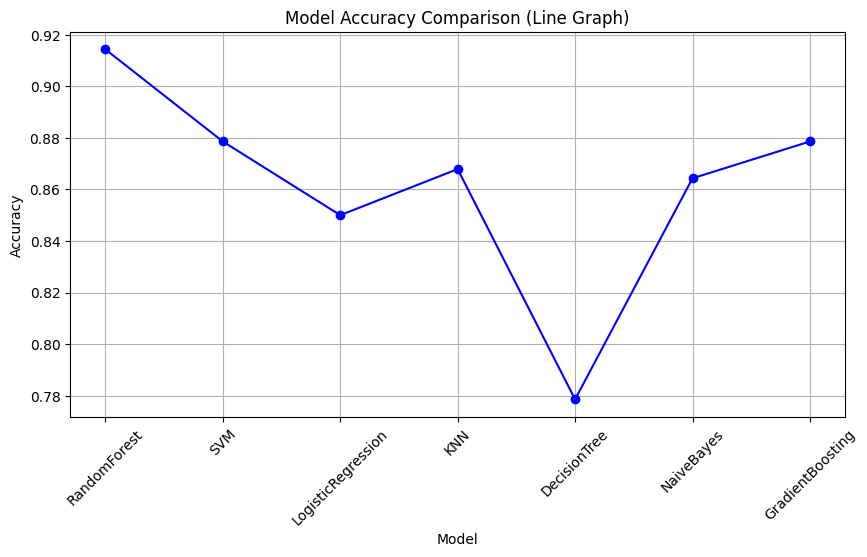

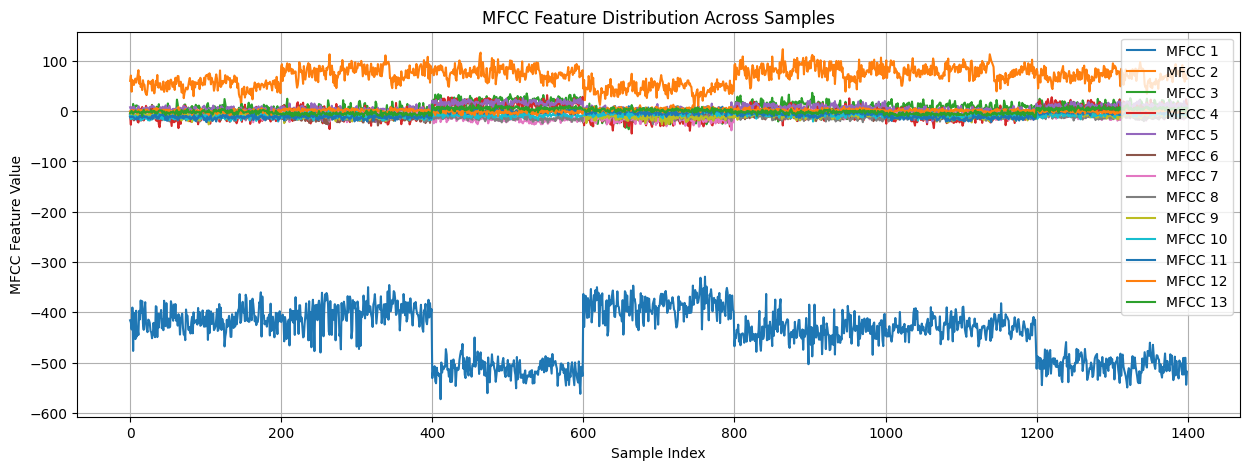

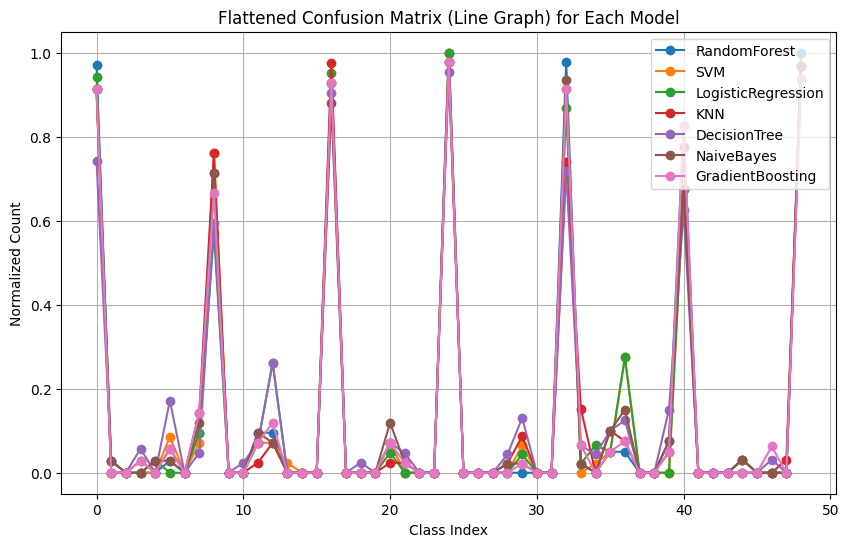

In [23]:

# Dictionary to store accuracies and confusion matrices for each model
model_accuracies = {}
model_conf_matrices = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_accuracies[model_name] = accuracy_score(y_test, y_pred)
    model_conf_matrices[model_name] = confusion_matrix(y_test, y_pred)

# Plot model accuracies as a line graph
def plot_model_accuracy_line(model_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(list(model_accuracies.keys()), list(model_accuracies.values()), marker='o', color='b', linestyle='-')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison (Line Graph)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Function to plot MFCC feature distribution as line graphs
def plot_mfcc_distribution_lines(X):
    plt.figure(figsize=(15, 5))
    for i in range(13):  # Plot each MFCC feature as a line
        plt.plot(X[:, i], label=f'MFCC {i+1}')
    plt.xlabel('Sample Index')
    plt.ylabel('MFCC Feature Value')
    plt.title('MFCC Feature Distribution Across Samples')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Function to plot confusion matrices for each model as line graphs
def plot_confusion_matrix_lines(model_conf_matrices, labels):
    fig, ax = plt.subplots(figsize=(10, 6))
    for model_name, conf_matrix in model_conf_matrices.items():
        # Normalize confusion matrix
        conf_matrix_normalized = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
        line_data = conf_matrix_normalized.flatten()
        ax.plot(line_data, marker='o', label=model_name)
    
    ax.set_title('Flattened Confusion Matrix (Line Graph) for Each Model')
    ax.set_xlabel('Class Index')
    ax.set_ylabel('Normalized Count')
    ax.legend(loc='upper right')
    ax.grid(True)
    plt.show()

# Call the plotting functions
plot_model_accuracy_line(model_accuracies)
plot_mfcc_distribution_lines(X)
plot_confusion_matrix_lines(model_conf_matrices, emotions)

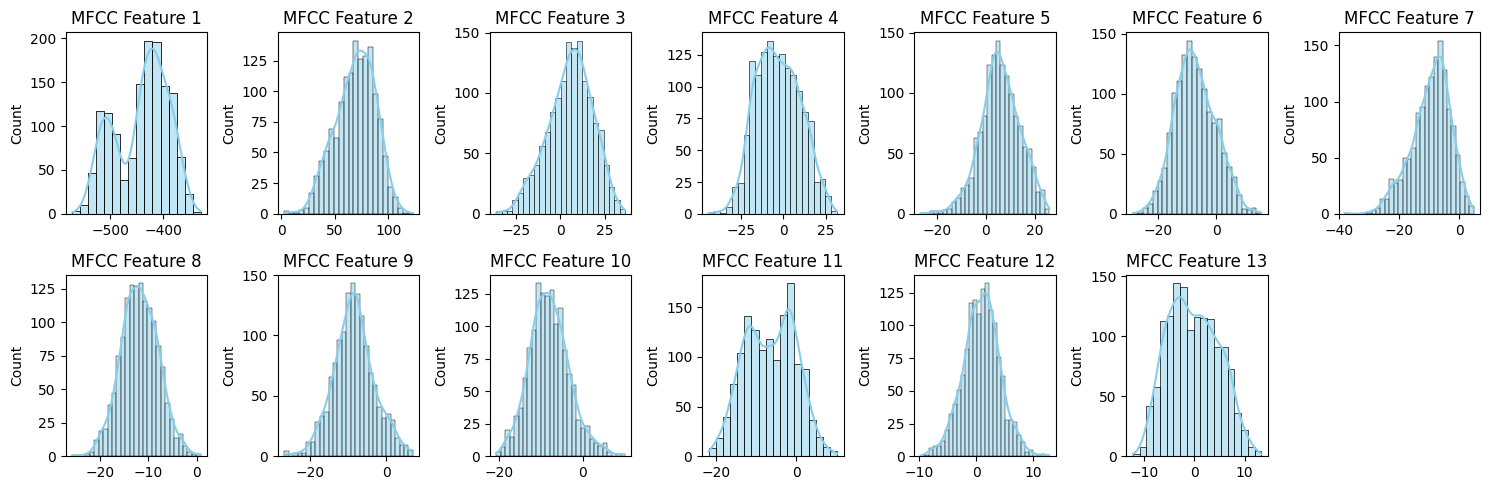

C:\Users\91799\AppData\Local\Temp\ipykernel_3940\2333138315.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette="viridis")


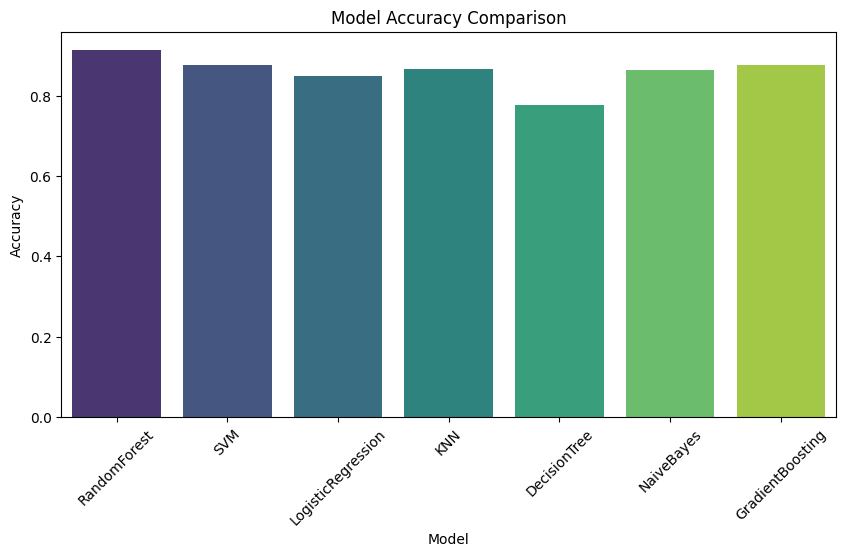

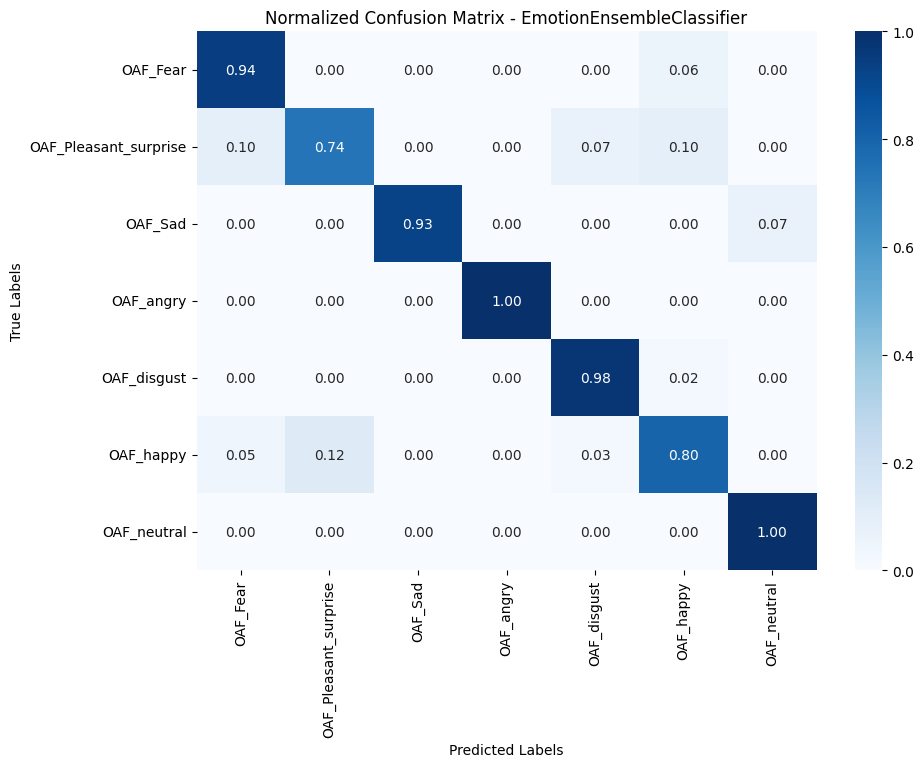

In [24]:

# Feature Distribution Visualization
plt.figure(figsize=(15, 5))
for i in range(13):  # MFCC typically has 13 coefficients
    plt.subplot(2, 7, i + 1)
    sns.histplot(X[:, i], kde=True, color='skyblue', edgecolor='black')
    plt.title(f'MFCC Feature {i+1}')
plt.tight_layout()
plt.show()

# Plot Accuracy of Each Model
model_names = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

plt.figure(figsize=(10, 5))
sns.barplot(x=model_names, y=accuracies, palette="viridis")
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()

# Normalized Confusion Matrix
conf_matrix_normalized = confusion_matrix(y_test, y_pred_ensemble, normalize='true')

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=emotions, yticklabels=emotions)
plt.title('Normalized Confusion Matrix - EmotionEnsembleClassifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



EmotionEnsembleClassifier (Top 3 models) Accuracy: 91.07%


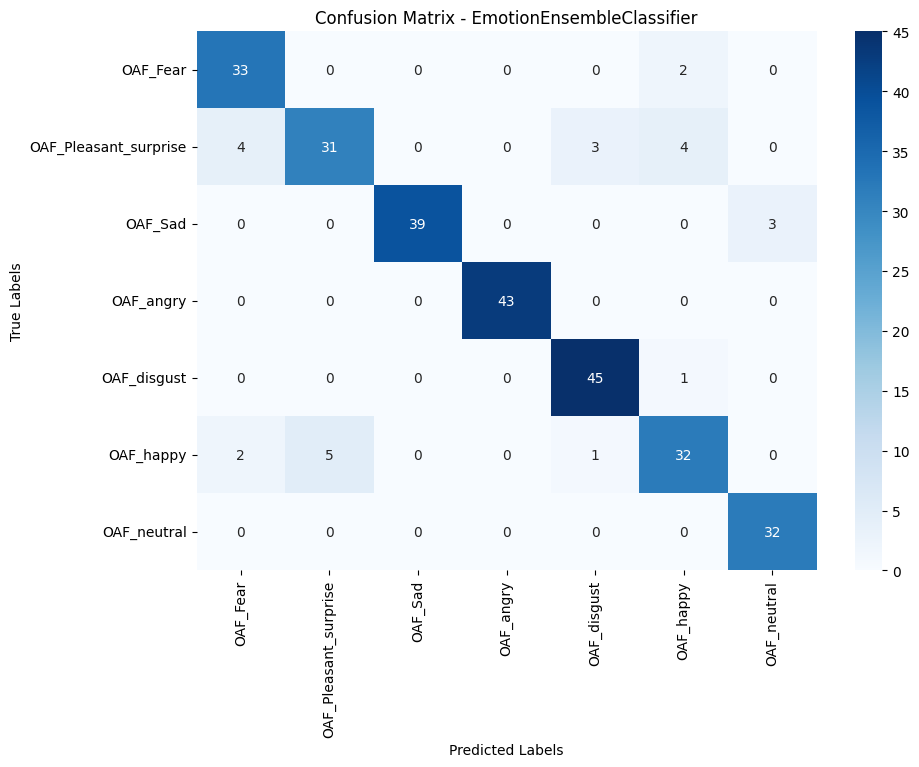

In [25]:
# Make predictions with the ensemble model
y_pred_ensemble = ensemble_model.predict(X_test)

# Calculate accuracy of the ensemble model
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f'\nEmotionEnsembleClassifier (Top 3 models) Accuracy: {ensemble_accuracy * 100:.2f}%')

# Confusion matrix for the ensemble model
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=emotions, yticklabels=emotions)
plt.title('Confusion Matrix - EmotionEnsembleClassifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### Save the Model

In [26]:
# Save the ensemble model to a file
joblib.dump(ensemble_model, 'EmotionEnsembleClassifier.joblib')
print("\nEmotionEnsembleClassifier model saved as 'EmotionEnsembleClassifier.joblib'")



EmotionEnsembleClassifier model saved as 'EmotionEnsembleClassifier.joblib'


In [27]:
# Function to predict the emotion from a single audio file
def predict_emotion(audio_path, model, emotions_list):
    # Extract MFCC features from the audio file
    mfcc_features = extract_mfcc(audio_path)
    
    if mfcc_features is None:
        print("Could not process the audio file.")
        return None
    
    # Reshape the features array for prediction (1 sample, n_features)
    mfcc_features = mfcc_features.reshape(1, -1)
    
    # Make the prediction
    prediction = model.predict(mfcc_features)
    
    # Get the predicted emotion label
    predicted_emotion = prediction[0]
    print(f"Predicted emotion: {predicted_emotion}")
    return predicted_emotion

# Load the trained ensemble model
loaded_model = joblib.load('EmotionEnsembleClassifier.joblib')

# Test the function with a single audio file
test_audio_path = "OAF_bath_happy.wav"  # Replace with your audio file path
predicted_emotion = predict_emotion(test_audio_path, loaded_model, emotions)

# Display the predicted emotion
if predicted_emotion:
    print(f"The emotion detected in the audio file is: {predicted_emotion}")


Predicted emotion: OAF_happy
The emotion detected in the audio file is: OAF_happy


In [28]:
def print_project_analysis():
    print("Speech Emotion Detection Machine Learning Project\n")
    
    print("1. Data Preparation and Feature Extraction")
    print("   - Dataset: Audio files labeled by emotion, located in subfolders in the `archive/wave` directory.")
    print("   - Emotion Classes: Seven different emotions are considered for classification: "
          "`OAF_Fear`, `OAF_Pleasant_surprise`, `OAF_Sad`, `OAF_angry`, `OAF_disgust`, "
          "`OAF_happy`, and `OAF_neutral`.")
    print("   - Feature Extraction: MFCC (Mel Frequency Cepstral Coefficients) features are extracted from each audio file "
          "to capture the unique characteristics of speech for each emotion. Each file is represented by 13 MFCC coefficients, "
          "resulting in an array with a shape of `(1400, 13)`.\n")

    print("2. Model Training and Evaluation")
    print("   - Seven machine learning models were trained:")
    print("     - RandomForestClassifier")
    print("     - Support Vector Machine (SVM)")
    print("     - Logistic Regression")
    print("     - K-Nearest Neighbors (KNN)")
    print("     - Decision Tree")
    print("     - Naive Bayes")
    print("     - Gradient Boosting")
    print("   - Accuracy Results:")
    print("     - RandomForest: 91.43%")
    print("     - SVM: 87.86%")
    print("     - Logistic Regression: 85.00% (Convergence warning received due to limited iterations)")
    print("     - KNN: 86.79%")
    print("     - Decision Tree: 77.86%")
    print("     - Naive Bayes: 86.43%")
    print("     - Gradient Boosting: 87.86%\n")
    
    print("   - Analysis:")
    print("     - RandomForest achieved the highest individual accuracy at 91.43%, likely due to its ability to handle complex data patterns.")
    print("     - SVM and Gradient Boosting also performed strongly, both at 87.86%.")
    print("     - Logistic Regression was hindered slightly by reaching iteration limits, but still provided a solid accuracy of 85.00%.")
    print("     - Decision Tree had a notably lower performance, with an accuracy of 77.86%, likely due to sensitivity to noise.\n")
    
    print("3. Ensemble Model: EmotionEnsembleClassifier")
    print("   - Top 3 Models: Based on individual accuracy, the top three models selected for ensemble training were "
          "RandomForest, SVM, and Gradient Boosting.")
    print("   - VotingClassifier: These models were combined in a VotingClassifier (using majority voting) to form the `EmotionEnsembleClassifier`.")
    print("   - Ensemble Accuracy: The ensemble achieved an accuracy of 91.07% on the test set, closely matching the highest individual model.\n")
    
    print("4. Model Visualization and Evaluation")
    print("   - Feature Distribution: Histograms for each MFCC feature showed slight spread in the data, indicating distinct characteristics for each emotion.")
    print("   - Model Accuracy Comparison: A bar plot confirmed RandomForest leading, closely followed by SVM and Gradient Boosting.")
    print("   - Confusion Matrix:")
    print("     - Normalized Confusion Matrix: Shows the percentage of correct and incorrect predictions for each emotion.")
    print("     - Regular Confusion Matrix: Provides raw counts of correct and incorrect classifications.")
    print("     - Interpretation: Some emotions like `OAF_neutral` and `OAF_sad` are acoustically similar, leading to classification challenges.\n")
    
    print("5. Model Persistence")
    print("   - The ensemble model (`EmotionEnsembleClassifier`) was saved using `joblib`, allowing reuse without retraining.\n")
    
    print("6. Conclusion and Recommendations")
    print("   - Overall Performance: The `EmotionEnsembleClassifier` demonstrated high accuracy, effectively distinguishing between complex emotions in speech.")
    print("   - Strengths:")
    print("     - The ensemble model combines strengths of multiple classifiers, enhancing robustness.")
    print("     - MFCC features effectively capture essential audio characteristics.")
    print("   - Improvements:")
    print("     - Consider increasing data diversity to improve accuracy, especially for similar emotions.")
    print("     - Experimenting with hyperparameter tuning could yield better performance.")
    print("     - Future enhancements could involve deep learning models like CNNs or LSTMs with a larger dataset.\n")
    
    print("Final Remarks:")
    print("   - The `EmotionEnsembleClassifier` has demonstrated success in identifying emotions from speech.")
    print("   - It can serve as a foundational model in applications like call center analysis, personal assistants, or therapy aids.\n")

# Call the function to print the analysis
print_project_analysis()


Speech Emotion Detection Machine Learning Project

1. Data Preparation and Feature Extraction
   - Dataset: Audio files labeled by emotion, located in subfolders in the `archive/wave` directory.
   - Emotion Classes: Seven different emotions are considered for classification: `OAF_Fear`, `OAF_Pleasant_surprise`, `OAF_Sad`, `OAF_angry`, `OAF_disgust`, `OAF_happy`, and `OAF_neutral`.
   - Feature Extraction: MFCC (Mel Frequency Cepstral Coefficients) features are extracted from each audio file to capture the unique characteristics of speech for each emotion. Each file is represented by 13 MFCC coefficients, resulting in an array with a shape of `(1400, 13)`.

2. Model Training and Evaluation
   - Seven machine learning models were trained:
     - RandomForestClassifier
     - Support Vector Machine (SVM)
     - Logistic Regression
     - K-Nearest Neighbors (KNN)
     - Decision Tree
     - Naive Bayes
     - Gradient Boosting
   - Accuracy Results:
     - RandomForest: 91.43%
     - SVM